In [2]:
import pandas as pd
from six.moves import cPickle
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout


Using TensorFlow backend.


In [4]:
from google.colab import files
uploaded = files.upload()

Saving airbnb-dataset-of-barcelona-city.zip to airbnb-dataset-of-barcelona-city.zip


In [5]:
ls

airbnb-dataset-of-barcelona-city.zip  sample_data/


In [6]:
!unzip  'airbnb-dataset-of-barcelona-city.zip'

Archive:  airbnb-dataset-of-barcelona-city.zip
  inflating: tomslee_airbnb_barcelona_1477_2017-07-23.csv  
  inflating: barca.csv               
  inflating: barca_shuffle.csv       


In [0]:
df1=pd.read_csv("tomslee_airbnb_barcelona_1477_2017-07-23.csv")
df2=pd.read_csv("barca.csv")
df3=pd.read_csv("barca_shuffle.csv")

In [8]:
print(df2.columns)
print(df3.columns)
#print (df2 == df3).all()[0]

Index(['room_type', 'neighborhood', 'reviews', 'overall_satisfaction',
       'accommodates', 'bedrooms', 'price', 'latitude', 'longitude'],
      dtype='object')
Index(['0', 'room_type', 'neighborhood', 'overall_satisfaction',
       'accommodates', 'bedrooms', 'price', 'latitude', 'longitude'],
      dtype='object')


In [13]:
df1.columns

Index(['room_id', 'survey_id', 'host_id', 'room_type', 'country', 'city',
       'borough', 'neighborhood', 'reviews', 'overall_satisfaction',
       'accommodates', 'bedrooms', 'bathrooms', 'price', 'minstay', 'name',
       'last_modified', 'latitude', 'longitude', 'location'],
      dtype='object')

In [78]:
print(df1['room_type'].value_counts())
print(df2['room_type'].value_counts())

Private room       9821
Entire home/apt    8877
Shared room         140
Name: room_type, dtype: int64
Private room       6526
Entire home/apt    6024
Shared room          83
Name: room_type, dtype: int64


In [20]:
df1.head()

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,name,last_modified,latitude,longitude,location
0,12331794,1477,41933599,Shared room,NaN,Barcelona,NaN,Eixample,0,0.0,5,1.0,NaN,211.0,NaN,5-bed mixed dorm at Sleep Green Y.H,2017-07-28 14:49:29.434152,41.387023,2.167047,0101000020E6100000C828CFBC1C56014060E63BF889B1...
1,12331935,1477,41933599,Shared room,NaN,Barcelona,NaN,Eixample,0,0.0,6,1.0,NaN,253.0,NaN,6-bed mixed dorm at Sleep Green Y.H,2017-07-28 14:49:29.431042,41.387658,2.167093,0101000020E6100000CD1FD3DA34560140320400C79EB1...
2,12332051,1477,41933599,Shared room,NaN,Barcelona,NaN,Eixample,0,0.0,8,1.0,NaN,289.0,NaN,8-bed mixed dorm at ACYHostel,2017-07-28 14:49:29.427665,41.387962,2.165981,0101000020E61000001B0FB6D8ED5301409E0B23BDA8B1...
3,4627938,1477,23968212,Shared room,NaN,Barcelona,NaN,Eixample,27,4.5,10,1.0,NaN,264.0,NaN,THE HIPSTEL hostel 1 BED IN DORM-10 Shared WC,2017-07-28 14:49:29.424265,41.391617,2.162516,0101000020E6100000289D4830D54C014060C77F8120B2...
4,12331497,1477,41933599,Shared room,NaN,Barcelona,NaN,Eixample,0,0.0,4,1.0,NaN,169.0,NaN,4-bed mixed dorm at Sleep Green Y.H,2017-07-28 14:49:25.542467,41.386288,2.165477,0101000020E6100000EAEBF99AE55201402B6B9BE271B1...


In [22]:
ids = df1["room_id"]

#so there are no duplicates in roomid
df1[ids.isin(ids[ids.duplicated()])].sort_values("room_id")

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,name,last_modified,latitude,longitude,location


In [26]:
ids = df1["host_id"]

#so there are 
df1[ids.isin(ids[ids.duplicated()])].sort_values("host_id").shape            #there are repeats with respect to the host Id so we will be using it and creating 

(10586, 20)

In [25]:
df1.shape

(18838, 20)

In [28]:
df3.head()

,0,room_type,neighborhood,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude
0,poco visitado,Shared room,Eixample,4.5,10,1.0,264.0,41.391617,2.162516
1,poco visitado,Shared room,Sants-Montjuïc,4.0,12,1.0,129.0,41.373268,2.170138
2,poco visitado,Shared room,Sants-Montjuïc,4.0,12,1.0,129.0,41.372360,2.169215
3,poco visitado,Shared room,Eixample,5.0,2,1.0,72.0,41.391836,2.154014
4,poco visitado,Shared room,Eixample,5.0,2,1.0,64.0,41.387623,2.148761


In [29]:
df2.head()

,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude
0,Shared room,Eixample,27,4.5,10,1.0,264.0,41.391617,2.162516
1,Shared room,Sants-Montjuïc,13,4.0,12,1.0,129.0,41.373268,2.170138
2,Shared room,Sants-Montjuïc,11,4.0,12,1.0,129.0,41.372360,2.169215
3,Shared room,Eixample,9,5.0,2,1.0,72.0,41.391836,2.154014
4,Shared room,Eixample,10,5.0,2,1.0,64.0,41.387623,2.148761


In [34]:
print(df2.shape)
print(df3.shape)

(12633, 9)
(12633, 9)


In [30]:
df3.head()

,0,room_type,neighborhood,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude
0,poco visitado,Shared room,Eixample,4.5,10,1.0,264.0,41.391617,2.162516
1,poco visitado,Shared room,Sants-Montjuïc,4.0,12,1.0,129.0,41.373268,2.170138
2,poco visitado,Shared room,Sants-Montjuïc,4.0,12,1.0,129.0,41.372360,2.169215
3,poco visitado,Shared room,Eixample,5.0,2,1.0,72.0,41.391836,2.154014
4,poco visitado,Shared room,Eixample,5.0,2,1.0,64.0,41.387623,2.148761


In [42]:
df3.shape

(12633, 9)

In [0]:
df2['Visit type']=df3['0']

In [43]:
df2.head()

,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude,Visit type
0,Shared room,Eixample,27,4.5,10,1.0,264.0,41.391617,2.162516,poco visitado
1,Shared room,Sants-Montjuïc,13,4.0,12,1.0,129.0,41.373268,2.170138,poco visitado
2,Shared room,Sants-Montjuïc,11,4.0,12,1.0,129.0,41.372360,2.169215,poco visitado
3,Shared room,Eixample,9,5.0,2,1.0,72.0,41.391836,2.154014,poco visitado
4,Shared room,Eixample,10,5.0,2,1.0,64.0,41.387623,2.148761,poco visitado


In [45]:
df2.shape

(12633, 10)

In [46]:
df1.shape

(18838, 20)

In [47]:
df1.isnull().sum()

room_id                     0
survey_id                   0
host_id                     0
room_type                   0
country                 18838
city                        0
borough                 18838
neighborhood                0
reviews                     0
overall_satisfaction        0
accommodates                0
bedrooms                    0
bathrooms               18838
price                       0
minstay                 18838
name                       47
last_modified               0
latitude                    0
longitude                   0
location                    0
dtype: int64

The entire column has na values so we will remove columns like 'country','bathrooms','minstay',borough

In [0]:
df1=df1.drop(columns=['country','bathrooms','minstay','borough'])

In [0]:
df1[['host_id','name']]                  #this is clear that one host has one group
grouped = df1.groupby('name')

In [60]:
df1.shape

(18838, 16)

In [82]:
#grouped.head()
df1.isnull().sum()
#(47/18838)*100  there are 2% NA values in dataset now , If we impute it and there is even a slight error then we will end up with a problem of false label ... so we will just impute it now

room_id                  0
survey_id                0
host_id                  0
room_type                0
city                     0
neighborhood             0
reviews                  0
overall_satisfaction     0
accommodates             0
bedrooms                 0
price                    0
name                    47
last_modified            0
latitude                 0
longitude                0
location                 0
dtype: int64

In [0]:
df1=df1.dropna()

In [65]:
df1.shape

(18791, 16)

In [0]:

df1=df1.drop(columns=['location'])    #We drop it as it is not interpretable 

In [73]:
print(df1.columns)

Index(['room_id', 'survey_id', 'host_id', 'room_type', 'city', 'neighborhood',
       'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'price',
       'name', 'last_modified'],
      dtype='object')


In [0]:
#recommendation 1
a=df2['latitude'].unique()

In [0]:
b=df1['latitude'].unique()

In [90]:
all(x in a for x in b)     # I was thinking of merging the two data frames but it seems all the values are not present so some columns will have null value and we cant use this approach 

False

So for our recommendation we will use only one dataframe and that is df1 ...The one will max records 

In [91]:
df1.head()

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name,last_modified,latitude,longitude
0,12331794,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,5,1.0,211.0,5-bed mixed dorm at Sleep Green Y.H,2017-07-28 14:49:29.434152,41.387023,2.167047
1,12331935,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,6,1.0,253.0,6-bed mixed dorm at Sleep Green Y.H,2017-07-28 14:49:29.431042,41.387658,2.167093
2,12332051,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,8,1.0,289.0,8-bed mixed dorm at ACYHostel,2017-07-28 14:49:29.427665,41.387962,2.165981
3,4627938,1477,23968212,Shared room,Barcelona,Eixample,27,4.5,10,1.0,264.0,THE HIPSTEL hostel 1 BED IN DORM-10 Shared WC,2017-07-28 14:49:29.424265,41.391617,2.162516
4,12331497,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,4,1.0,169.0,4-bed mixed dorm at Sleep Green Y.H,2017-07-28 14:49:25.542467,41.386288,2.165477


In [0]:
df1=df1.drop(columns=['latitude', 'longitude','last_modified','city','survey_id'])

In [98]:
print(df1.shape)
df1.head()

(18791, 12)


,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name
0,12331794,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,5,1.0,211.0,5-bed mixed dorm at Sleep Green Y.H
1,12331935,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,6,1.0,253.0,6-bed mixed dorm at Sleep Green Y.H
2,12332051,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,8,1.0,289.0,8-bed mixed dorm at ACYHostel
3,4627938,1477,23968212,Shared room,Barcelona,Eixample,27,4.5,10,1.0,264.0,THE HIPSTEL hostel 1 BED IN DORM-10 Shared WC
4,12331497,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,4,1.0,169.0,4-bed mixed dorm at Sleep Green Y.H


In [103]:
df1.loc[df1['reviews']==0].head()    #There are no ratings given for these 

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name
0,12331794,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,5,1.0,211.0,5-bed mixed dorm at Sleep Green Y.H
1,12331935,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,6,1.0,253.0,6-bed mixed dorm at Sleep Green Y.H
2,12332051,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,8,1.0,289.0,8-bed mixed dorm at ACYHostel
4,12331497,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,4,1.0,169.0,4-bed mixed dorm at Sleep Green Y.H
8,16552543,1477,46914366,Shared room,Barcelona,Sants-Montjuïc,0,0.0,9,1.0,73.0,Cama en dormitorio de 9 camas


#Reason can be new property 

In [0]:
#j=df1.groupby([ 'neighborhood','city'])

In [122]:
df1.describe()

,room_id,survey_id,host_id,reviews,overall_satisfaction,accommodates,bedrooms,price
count,1.879100e+04,18791.0,1.879100e+04,18791.000000,18791.000000,18791.000000,18791.000000,18791.000000
mean,1.158755e+07,1477.0,4.161650e+07,24.754138,3.061279,3.320153,1.521579,110.332606
std,6.558332e+06,0.0,4.392178e+07,39.700983,2.168264,2.202857,0.971466,118.435850
min,1.119400e+04,1477.0,1.007700e+04,0.000000,0.000000,1.000000,0.000000,10.000000
25%,5.612328e+06,1477.0,6.099660e+06,1.000000,0.000000,2.000000,1.000000,48.000000
50%,1.306139e+07,1477.0,2.273165e+07,8.000000,4.500000,2.000000,1.000000,78.000000
75%,1.789919e+07,1477.0,6.756417e+07,31.000000,4.500000,4.000000,2.000000,136.000000
max,2.009710e+07,1477.0,1.428879e+08,457.000000,5.000000,16.000000,10.000000,3606.000000


In [0]:
dfnew=df1.loc[df1['reviews'] == 0].head()   #these are those properties on whom the rating info is not used so we will drop it from this dataframe but store in another 

In [19]:
dfnew.head()

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name
0,12331794,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,5,1.0,211.0,5-bed mixed dorm at Sleep Green Y.H
1,12331935,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,6,1.0,253.0,6-bed mixed dorm at Sleep Green Y.H
2,12332051,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,8,1.0,289.0,8-bed mixed dorm at ACYHostel
4,12331497,1477,41933599,Shared room,Barcelona,Eixample,0,0.0,4,1.0,169.0,4-bed mixed dorm at Sleep Green Y.H
8,16552543,1477,46914366,Shared room,Barcelona,Sants-Montjuïc,0,0.0,9,1.0,73.0,Cama en dormitorio de 9 camas


In [0]:
df1.drop(df1.loc[df1['reviews']==0].index, inplace=True)

In [17]:
df1.loc[df1['reviews']==0]

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name


In [36]:
df1['neighborhood'].value_counts()

Eixample               5102
Ciutat Vella           3215
Sants-Montjuïc         1812
Sant Martí             1763
Gràcia                 1450
Sarrià-Sant Gervasi     562
Horta-Guinardó          518
Les Corts               294
Sant Andreu             250
Nou Barris              199
Name: neighborhood, dtype: int64

#Visualization 

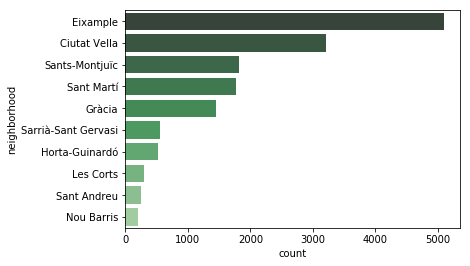

In [37]:
sns.countplot(y=df1['neighborhood'],data=df1, palette="Greens_d",
              order=df1['neighborhood'].value_counts().iloc[:10].index)                     #top 10 popular neighborhood ..

In [85]:
df1.head()

,index,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name,score
0,18536,674461,1477,3424464,Private room,Barcelona,Sants-Montjuïc,376,5.0,1,1.0,28.0,"CENTRIC, IDEAL TOURISTS, BREAKFAST",4.993830
1,17173,763176,1477,3424464,Private room,Barcelona,Sants-Montjuïc,339,5.0,2,1.0,34.0,"VERY CENTRIC, PERFECT FOR TOURISTS",4.993161
2,8625,590503,1477,6057270,Entire home/apt,Barcelona,Eixample,326,5.0,6,1.0,78.0,Cozy apartment ☼ perfect situation - metro & WIFI,4.992890
3,18488,1181739,1477,3424464,Private room,Barcelona,Sants-Montjuïc,324,5.0,3,1.0,39.0,VERY CENTRIC & SPACIOUS. Breakfast,4.992846
4,14631,270050,1477,1414100,Private room,Barcelona,Ciutat Vella,320,5.0,2,1.0,58.0,Double Room in El vaixell de paper,4.992757


1.0     4767
2.0     1708
3.0     1108
4.0      411
0.0      224
5.0       80
6.0       44
9.0        4
7.0        4
10.0       4
8.0        2
Name: bedrooms, dtype: int64


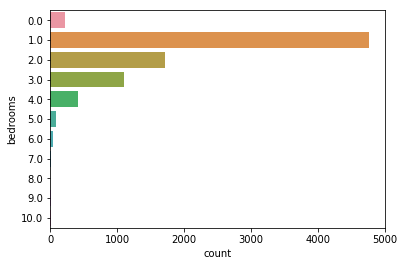

In [96]:
print(df1['bedrooms'].value_counts())
sns.countplot(y=df1['bedrooms'],data=df1)

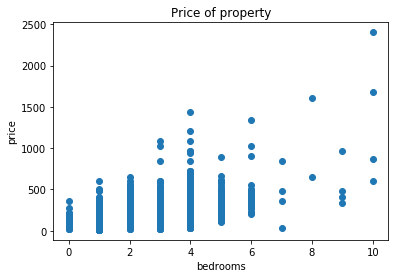

In [98]:
plt.scatter(df1['bedrooms'], df1['price'])

plt.title('Price of property')

plt.xlabel('bedrooms')

plt.ylabel('price')

plt.show()

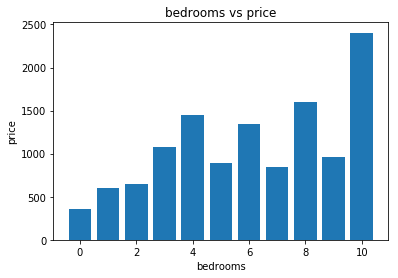

In [109]:


plt.bar(df1['bedrooms'], df1['price'])
plt.ylabel('price')
plt.xlabel('bedrooms')
plt.title('bedrooms vs price')

plt.show()

plt.show()


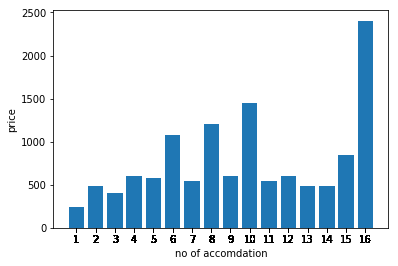

In [110]:

plt.bar(df1['accommodates'], df1['price'])
plt.xticks(df1['accommodates'])
plt.ylabel('price')
plt.xlabel('no of accomdation')
#plt.title('no of accomdation')

plt.show()

In [20]:
#where there is only one room per hotel we cant make recommendations to the host 
df_property = df1.groupby(['host_id'])['room_id'].nunique().sort_values(ascending=False)
df_property = pd.DataFrame(df_property)
df_property.tail()

,room_id
host_id,
41018859,1
41040631,1
41067283,1
41092915,1
10077,1


In [0]:

df_property_1 = df_property[df_property['room_id'] == 1]



In [0]:
l=df_property_1.index.tolist()

In [23]:
len(l)

6809

In [0]:
for i in l:
  df1.drop(df1.loc[df1['host_id']==i].index, inplace=True)
 

In [78]:
df1.shape

(8356, 12)

In [80]:
df1.head()

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name
5,12018424,1477,64212374,Shared room,Barcelona,Sants-Montjuïc,13,4.0,12,1.0,129.0,12 Bed Mixed Dorm Ensuite
6,12017913,1477,64212374,Shared room,Barcelona,Sants-Montjuïc,11,4.0,12,1.0,129.0,12 Bed Mixed Dorm Ensuite
7,11830051,1477,41807465,Shared room,Barcelona,Eixample,9,5.0,2,1.0,72.0,HEART OF BARCELONA : BED IN MIXED DORMITORY 2 ...
10,1823947,1477,9547606,Shared room,Barcelona,Sants-Montjuïc,67,4.0,16,1.0,45.0,Hostal esta 150 m del Camp Nou wifi
12,7965130,1477,41807465,Shared room,Barcelona,Eixample,6,4.5,8,1.0,289.0,PRIVATE ROOM FOR 8 PERSONS IN HEART OF BARCELO...


In [28]:
print (df1.shape)
print (df1_train.shape)
print (df1_test.shape)
assert len(df1_train.index & df1_test.index) == 0

(8356, 12)
(5515, 12)
(2841, 12)


In [29]:
df1.head()

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name
5,12018424,1477,64212374,Shared room,Barcelona,Sants-Montjuïc,13,4.0,12,1.0,129.0,12 Bed Mixed Dorm Ensuite
6,12017913,1477,64212374,Shared room,Barcelona,Sants-Montjuïc,11,4.0,12,1.0,129.0,12 Bed Mixed Dorm Ensuite
7,11830051,1477,41807465,Shared room,Barcelona,Eixample,9,5.0,2,1.0,72.0,HEART OF BARCELONA : BED IN MIXED DORMITORY 2 ...
10,1823947,1477,9547606,Shared room,Barcelona,Sants-Montjuïc,67,4.0,16,1.0,45.0,Hostal esta 150 m del Camp Nou wifi
12,7965130,1477,41807465,Shared room,Barcelona,Eixample,6,4.5,8,1.0,289.0,PRIVATE ROOM FOR 8 PERSONS IN HEART OF BARCELO...


In [125]:
df1.columns

Index(['room_id', 'survey_id', 'host_id', 'room_type', 'city', 'neighborhood',
       'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'price',
       'name', 'for_testing'],
      dtype='object')

In [145]:
X_train.shape
X_test.shape
y_train.shape

(5515, 10)

In [0]:
df1.head()
df1=df1.reset_index()

In [0]:
C=df1['overall_satisfaction'].mean()

v is the number of reviews  for the property;
m is the minimum reviews required to be listed in the chart;
R is the overall rationg of the room And
C is the mean rating  across the whole report

In [0]:
m=2    #in order to take recommendation at least 2 people should have recommended it 
def weighted_rating(x, m=m, C=C):
    v = x['reviews']
    R = x['overall_satisfaction']
    
    return (v/(v+m) * R) + (m/(m+v) * C)

In [0]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
df1['score'] = df1.apply(weighted_rating, axis=1)


In [37]:
df1['score'].value_counts().head()

2.555928    681
1.916946    547
4.233557    183
4.611297    151
4.533557    142
Name: score, dtype: int64

In [38]:
df1.columns

Index(['room_id', 'survey_id', 'host_id', 'room_type', 'city', 'neighborhood',
       'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'price',
       'name', 'score'],
      dtype='object')

In [39]:
#arranging with respect to score 
#Sort  based on score calculated above
df1 =df1.sort_values('score', ascending=False)

#Print the top 15 rooms
df1[['room_id','reviews', 'overall_satisfaction', 'score','host_id']].head(15)

,room_id,reviews,overall_satisfaction,score,host_id
18536,674461,376,5.0,4.993830,3424464
17173,763176,339,5.0,4.993161,3424464
8625,590503,326,5.0,4.992890,6057270
18488,1181739,324,5.0,4.992846,3424464
14631,270050,320,5.0,4.992757,1414100
7443,866315,320,5.0,4.992757,4427588
13258,3390888,287,5.0,4.991930,17107294
10093,3653695,283,5.0,4.991817,17923344
15079,380421,276,5.0,4.991611,1414100
11536,1224736,272,5.0,4.991488,6680972


In [40]:

recommendation=df1.groupby('host_id')
recommendation.head()

#best room under the host 
recommendation.get_group(1414100) 


,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name,score
14631,270050,1477,1414100,Private room,Barcelona,Ciutat Vella,320,5.0,2,1.0,58.0,Double Room in El vaixell de paper,4.992757
15079,380421,1477,1414100,Private room,Barcelona,Ciutat Vella,276,5.0,2,1.0,58.0,Double room with a balcony,4.991611


In [0]:
#name is actually the feedback 

In [216]:
df1['name'].value_counts().head()

Modern/ central LOFT - Double BR - terrace/jacuzzi    6
Sagrada Familia Apartment                             6
SAGRADA FAMILIA .DOUBLE  ROOM (BCN)                   4
Habitacion individual                                 3
Habitación individual                                 3
Name: name, dtype: int64

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [0]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df1['name'])


In [43]:
tfidf_matrix.shape

(8356, 3412)

In [44]:
df1['room_id'].value_counts().head()

2770943     1
1144116     1
2237750     1
4556090     1
11275579    1
Name: room_id, dtype: int64

In [0]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [52]:
indices = pd.Series(df1.index, index=df1['room_id']).drop_duplicates()
print(indices)

room_id
674461         0
763176         1
590503         2
1181739        3
270050         4
866315         5
3390888        6
3653695        7
380421         8
1224736        9
1754460       10
2252574       11
1013513       12
906559        13
1530586       14
1478299       15
811918        16
3560163       17
1677706       18
1304470       19
5176854       20
1256137       21
5176644       22
900045        23
1100506       24
2469678       25
1728329       26
208684        27
1109989       28
1251629       29
            ... 
16357497    8326
14275656    8327
19450748    8328
19787197    8329
17083350    8330
1248789     8331
19034744    8332
18533621    8333
13522508    8334
19823432    8335
19153820    8336
19263271    8337
3357564     8338
19269208    8339
8978226     8340
11396341    8341
16375985    8342
19747971    8343
7431713     8344
12468621    8345
18173821    8346
17741038    8347
4970715     8348
17903826    8349
11502685    8350
18030645    8351
16059196    8352
129262

In [0]:
# Function that takes in roomid as input and outputs most similar room
def get_recommendations(room_id, cosine_sim=cosine_sim):
    # Get the index of the room that matches the room
    idx = indices[room_id]

    # Get the pairwsie similarity scores of all room with that room
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the room based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar room
    sim_scores = sim_scores[1:11]

    # Get the room indices
    room_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar room
    return df1['room_id'].iloc[room_indices]

In [54]:
df1['city'].value_counts().head(10)

Barcelona    8356
Name: city, dtype: int64

In [0]:
k=get_recommendations(590503)          #recommmendation for room_id '18623807'

In [84]:
#content based recommendation 
df1.loc[df1['room_id'].isin(k)]     #based on name and room_id 

,index,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,name,score
932,5177,18213035,1477,90085502,Entire home/apt,Barcelona,Sant Martí,16,5.0,5,3.0,108.0,Very cozy apartment !!!,4.870432
2295,13700,9908619,1477,48848676,Private room,Barcelona,Eixample,91,4.5,2,1.0,54.0,"Cozy, perfect for 2 @ Rambla",4.485675
2558,8140,2564065,1477,1760302,Entire home/apt,Barcelona,Eixample,70,4.5,2,0.0,74.0,Cozy Apartment for 2 - WIFI,4.481497
3031,6577,3441799,1477,2041901,Entire home/apt,Barcelona,Gràcia,48,4.5,4,1.0,114.0,"Cozy, with terrace, Wifi and A/C",4.473356
4285,4571,6487044,1477,3678711,Entire home/apt,Barcelona,Gràcia,17,4.5,5,2.0,130.0,PERFECT LOCATED apartment with WIFI,4.429883
4656,5592,16891698,1477,6776202,Entire home/apt,Barcelona,Sant Andreu,12,4.5,5,2.0,114.0,Cozy apartment S -1,4.404842
4817,4213,16334092,1477,106907544,Entire home/apt,Barcelona,Eixample,10,4.5,8,3.0,144.0,Cozy Apartment!,4.388982
5726,7169,2626883,1477,11070021,Entire home/apt,Barcelona,Nou Barris,106,4.0,4,3.0,96.0,"Economical apartment near the metro, WiFi",3.996924
6377,15845,18585244,1477,85847207,Private room,Barcelona,Les Corts,13,4.0,2,1.0,41.0,5 Cozy Room 2 beds + Wifi + Metro + futbol,3.977852
6841,15168,14718397,1477,10445396,Private room,Barcelona,Eixample,3,3.5,4,2.0,16.0,"COZY ROOMS, PERFECT LOCATION!",3.633557


#Evaluation metrics  for The recommendation made to the host ,  about the best rooms in his property

In [0]:

def assign_to_set(df1):
    sampled_ids = np.random.choice(df1.index,
                                   size=np.int64(np.ceil(df1.index.size * 0.2)),
                                   replace=False)
    df1.ix[sampled_ids, 'for_testing'] = True
    return df1

df1['for_testing'] = False
grouped = df1.groupby('host_id', group_keys=False).apply(assign_to_set)
df1_train =df1[grouped.for_testing == False]
df1_test =df1[grouped.for_testing == True]
df1=df1.drop(columns=['for_testing'])

In [67]:
print(df1_train.shape)

print(df1_test.shape)

(5515, 15)
(2841, 15)


In [69]:

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))
def evaluate(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(df1_test.host_id, df1_test.room_id)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = df1_test.score.values
    return compute_rmse(estimated, real)
def my_estimate_function(host_id,room_id):
    return 3
print ('RMSE for my estimate function: %s' % evaluate(my_estimate_function))

RMSE for my estimate function: 1.3967294261489693
